"Can we identify the ranges (or combinations) of features that optimize a composite metric of yield and nutritional quality?"

By combining:

Weight Yield per Unit Area (WYUA) = (W3S / 300) * SYUA

and Protein Percentage (PPE)

Analyze which input feature ranges (like C, S, G, chlorophyll, plant height, etc.) contribute to higher values of this new composite metric.

Optimize Feature Ranges for Composite Production Metric

1. Define and Add the Composite Metric

In [101]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [102]:
# # Load your dataset with all features
# df_full = pd.read_csv("3_one_hot_encoded.csv").drop_duplicates()

# df_full.replace({True: 1, False: 0}, inplace=True)

# # Drop NA on required columns
# df_full = df_full.dropna(subset=["Weight of 300 Seeds (W3S)", "Seed Yield per Unit Area (SYUA)", "Protein Percentage (PPE)"])

# # Calculate new feature: WYUA = (W3S / 300) * SYUA
# df_full["WYUA"] = (df_full["Weight of 300 Seeds (W3S)"] / 300) * df_full["Seed Yield per Unit Area (SYUA)"]

# # Composite Score = Equal weighted sum
# df_full["Composite_Yield_Metric"] = (df_full["WYUA"] + df_full["Protein Percentage (PPE)"]) / 2

In [103]:
# -----------------------------------------
# 📦 Load & Prepare Data for Composite Metric
# -----------------------------------------

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
df_full = pd.read_csv("3_one_hot_encoded.csv").drop_duplicates()

# Convert True/False to 1/0
df_full.replace({True: 1, False: 0}, inplace=True)

# Drop rows with missing values in required columns
df_full = df_full.dropna(subset=["Weight of 300 Seeds (W3S)", "Seed Yield per Unit Area (SYUA)", "Protein Percentage (PPE)"])

# -----------------------------------------
# 📐 Step 1: Calculate WYUA (Weight × Yield per Area)
# -----------------------------------------
df_full["WYUA"] = (df_full["Weight of 300 Seeds (W3S)"] / 300) * df_full["Seed Yield per Unit Area (SYUA)"]

# -----------------------------------------
# 🔁 Step 2: Scale WYUA and PPE separately
# -----------------------------------------
scaler = MinMaxScaler()

# Fit and transform both features
scaled_features = scaler.fit_transform(df_full[["WYUA", "Protein Percentage (PPE)"]])
df_full["WYUA_scaled"] = scaled_features[:, 0]
df_full["PPE_scaled"] = scaled_features[:, 1]

# -----------------------------------------
# 🎯 Step 3: Compute final composite metric
# -----------------------------------------
df_full["Composite_Yield_Metric"] = ((df_full["WYUA_scaled"] + df_full["PPE_scaled"]) / 2) * 100  # scaled to [0, 100]

# Check results
df_full[["WYUA", "Protein Percentage (PPE)", "WYUA_scaled", "PPE_scaled", "Composite_Yield_Metric"]].head()


,WYUA,Protein Percentage (PPE),WYUA_scaled,PPE_scaled,Composite_Yield_Metric
0,623.548800,33.2,0.450895,0.238636,34.476555
1,257.484000,38.5,0.066514,0.840909,45.371156
2,507.666133,33.6,0.329214,0.284091,30.665242
3,1083.394500,33.5,0.933749,0.272727,60.323797
4,405.371200,39.6,0.221801,0.965909,59.385490


 2. Visualize Target Distribution

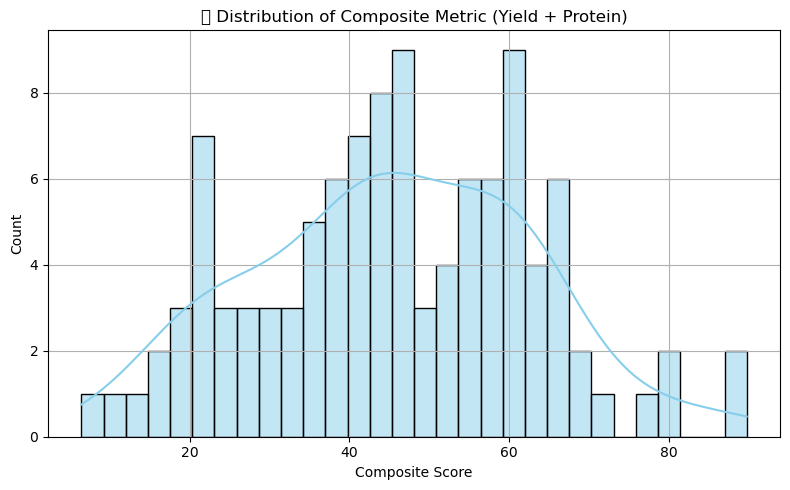

In [104]:
plt.figure(figsize=(8, 5))
sns.histplot(df_full["Composite_Yield_Metric"], kde=True, bins=30, color="skyblue")
plt.title("📈 Distribution of Composite Metric (Yield + Protein)")
plt.xlabel("Composite Score")
plt.grid(True)
plt.tight_layout()
plt.show()


3. Train Regression Model to Learn Influential Features

In [151]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Use all features except Parameters/Random/target
drop_cols = ["Parameters", "Random ", "Composite_Yield_Metric", "WYUA", "SYUA", "PPE", "Sugars (Su)", "Weight of 300 Seeds (W3S)",
            "Seed Yield per Unit Area (SYUA)", "Number of Seeds per Pod (NSP)",
            "Protein Percentage (PPE)", "Protein Content (PCO)", "WYUA_scaled", "PPE_scaled"]
X = df_full.drop(columns=drop_cols, errors='ignore')
y = df_full["Composite_Yield_Metric"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1, shuffle=True)

# Regressor
reg = GradientBoostingRegressor(random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
# Evaluate model
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"✅ Mean Squared Error on Test: {mape:.3f}")
print(f"✅ R² Score on Test: {r2:.3f}")

print(f"✅ R² Score on Test: {r2_score(y_test, reg.predict(X_test)):.3f}")
from sklearn.metrics import accuracy_score

# Assuming a threshold of 50 for classification
y_test_class = (y_test >= 50).astype(int)
y_pred_class = (y_pred >= 50).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"✅ Accuracy Score: {accuracy:.2f}")

✅ Mean Squared Error on Test: 14.809
✅ R² Score on Test: -0.161
✅ R² Score on Test: -0.161
✅ Accuracy Score: 0.73


 4. Use SHAP to Find Feature Ranges That Boost Composite Score

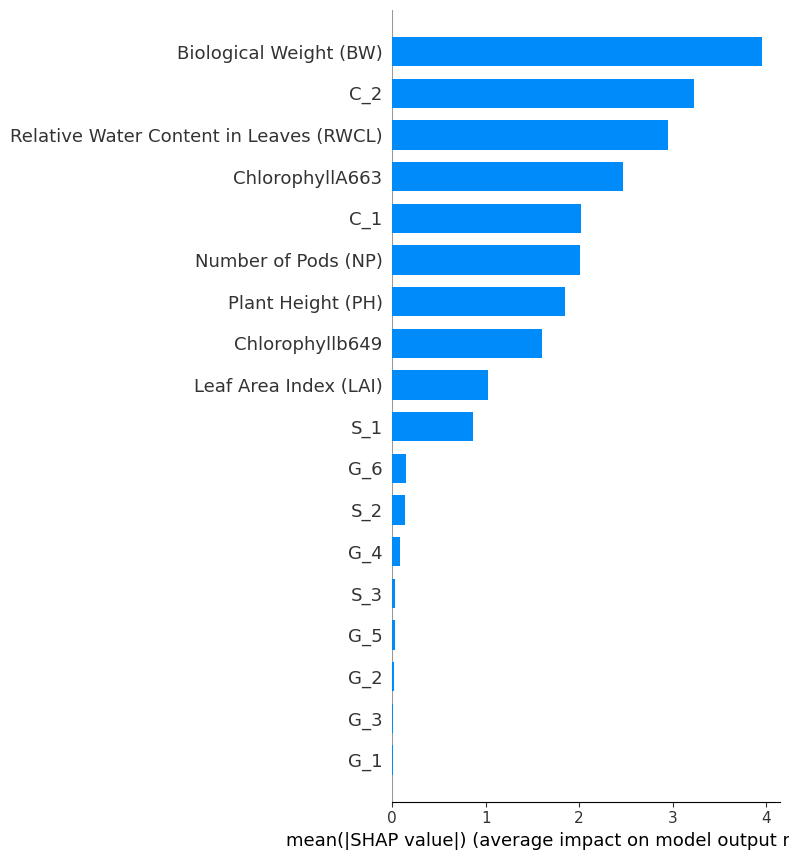

In [106]:
explainer = shap.Explainer(reg, X)
shap_values = explainer(X)

# Summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

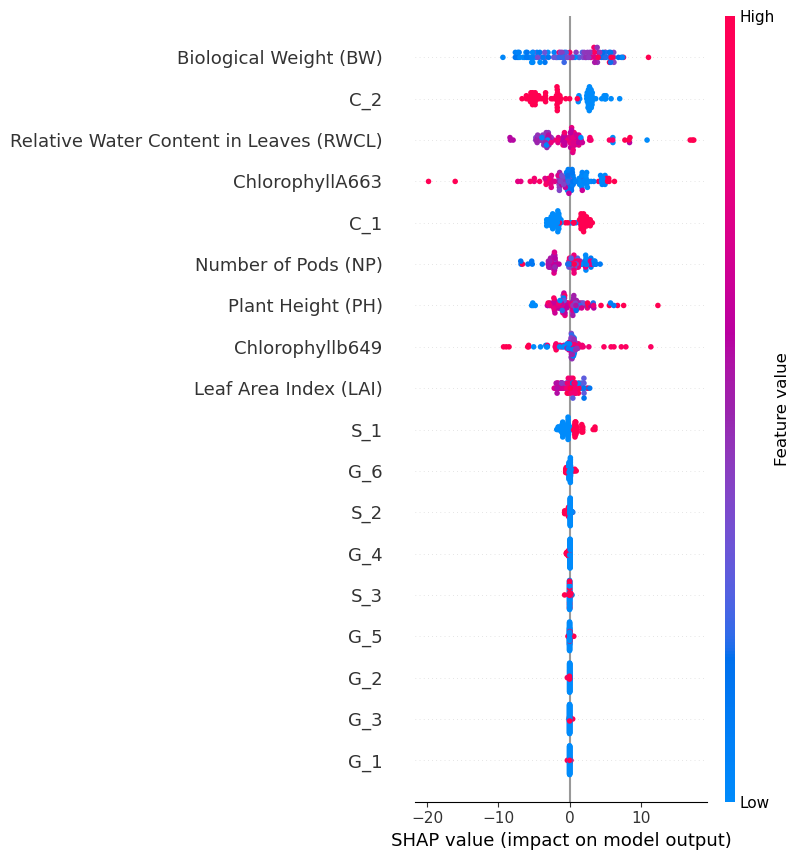

In [107]:
shap.summary_plot(shap_values, X)


5. Slice Data to Analyze High Scorers (Top 10–20%)

In [108]:
# Threshold to filter top 20% scorers
threshold = df_full["Composite_Yield_Metric"].quantile(0.80)

df_top = df_full[df_full["Composite_Yield_Metric"] >= threshold]

print(f"🔍 Top 20% samples: {len(df_top)} / {len(df_full)}")

# Describe important feature ranges in top data
important_features = shap_values.abs.mean(0).values.argsort()[::-1][:15]  # top 10 features
top_feature_names = X.columns[important_features]

df_top[top_feature_names].describe()


🔍 Top 20% samples: 22 / 108


,Biological Weight (BW),C_2,Relative Water Content in Leaves (RWCL),ChlorophyllA663,C_1,Number of Pods (NP),Plant Height (PH),Chlorophyllb649,Leaf Area Index (LAI),S_1,G_6,S_2,G_4,S_3,G_5
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.0,22.000000,22.000000,22.000000,22.000000
mean,136.772727,0.181818,0.691045,3.645455,0.818182,148.695455,50.250000,2.645455,0.077727,0.363636,0.0,0.136364,0.181818,0.500000,0.318182
std,52.296710,0.394771,0.110172,3.142902,0.394771,19.795153,3.721207,0.806950,0.020686,0.492366,0.0,0.351250,0.394771,0.511766,0.476731
min,67.000000,0.000000,0.434000,1.000000,0.000000,128.000000,42.300000,1.100000,0.040000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,102.500000,0.000000,0.667500,1.425000,1.000000,129.250000,49.550000,2.150000,0.060000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,127.500000,0.000000,0.690000,2.050000,1.000000,150.000000,51.000000,3.050000,0.080000,0.000000,0.0,0.000000,0.000000,0.500000,0.000000
75%,133.750000,0.000000,0.750000,5.950000,1.000000,159.750000,52.375000,3.275000,0.097500,1.000000,0.0,0.000000,0.000000,1.000000,1.000000
max,235.000000,1.000000,0.875000,10.000000,1.000000,209.000000,55.700000,3.600000,0.100000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [109]:
from sklearn.tree import DecisionTreeRegressor, export_text

tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X, y)

rules = export_text(tree, feature_names=list(X.columns))
print("📋 Decision Tree Rules for High Yield + Protein Composite:\n")
print(rules)


📋 Decision Tree Rules for High Yield + Protein Composite:

|--- Biological Weight (BW) <= 85.50
|   |--- C_2 <= 0.50
|   |   |--- Chlorophyllb649 <= 3.05
|   |   |   |--- Biological Weight (BW) <= 75.00
|   |   |   |   |--- value: [59.85]
|   |   |   |--- Biological Weight (BW) >  75.00
|   |   |   |   |--- value: [44.81]
|   |   |--- Chlorophyllb649 >  3.05
|   |   |   |--- Number of Pods (NP) <= 141.50
|   |   |   |   |--- value: [68.20]
|   |   |   |--- Number of Pods (NP) >  141.50
|   |   |   |   |--- value: [89.77]
|   |--- C_2 >  0.50
|   |   |--- ChlorophyllA663 <= 1.55
|   |   |   |--- Chlorophyllb649 <= 3.15
|   |   |   |   |--- value: [30.80]
|   |   |   |--- Chlorophyllb649 >  3.15
|   |   |   |   |--- value: [46.00]
|   |   |--- ChlorophyllA663 >  1.55
|   |   |   |--- G_6 <= 0.50
|   |   |   |   |--- value: [20.39]
|   |   |   |--- G_6 >  0.50
|   |   |   |   |--- value: [34.36]
|--- Biological Weight (BW) >  85.50
|   |--- Relative Water Content in Leaves (RWCL) <= 0.44


 Visualize Distributions (Top 20% vs All)

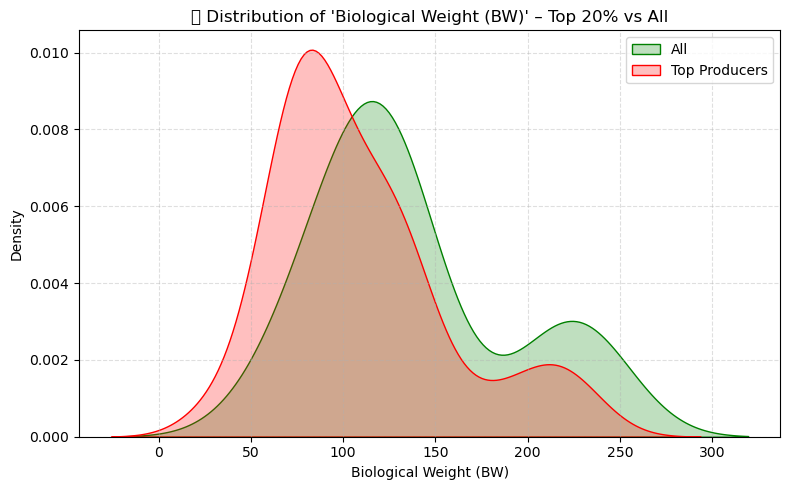

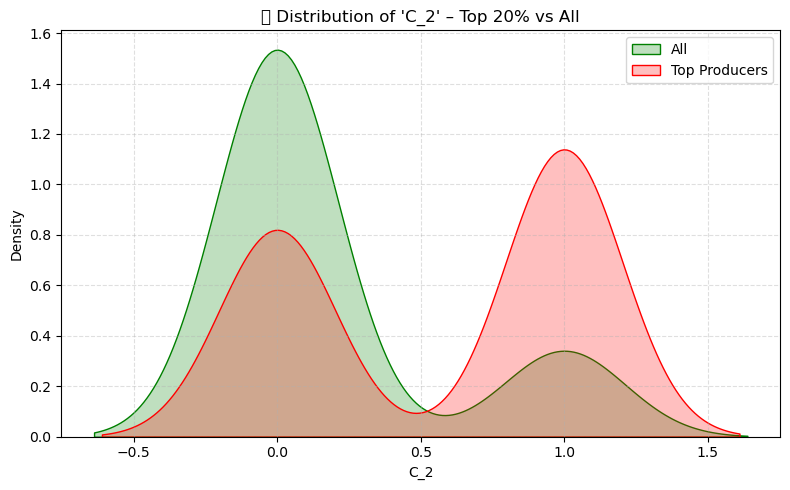

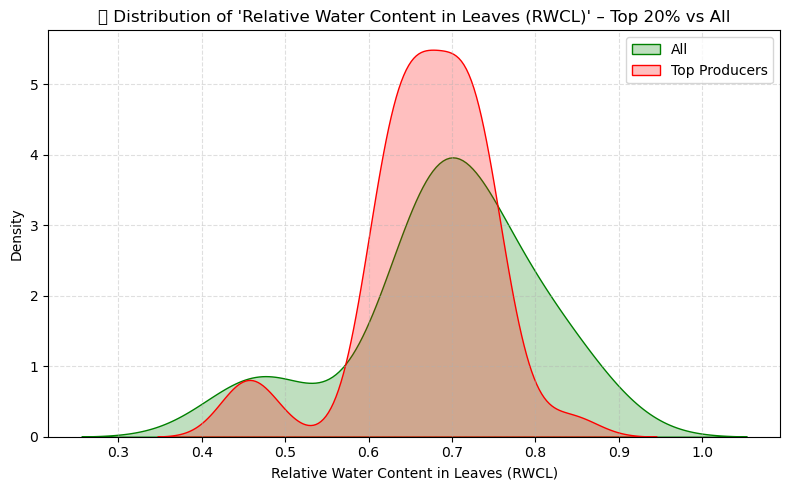

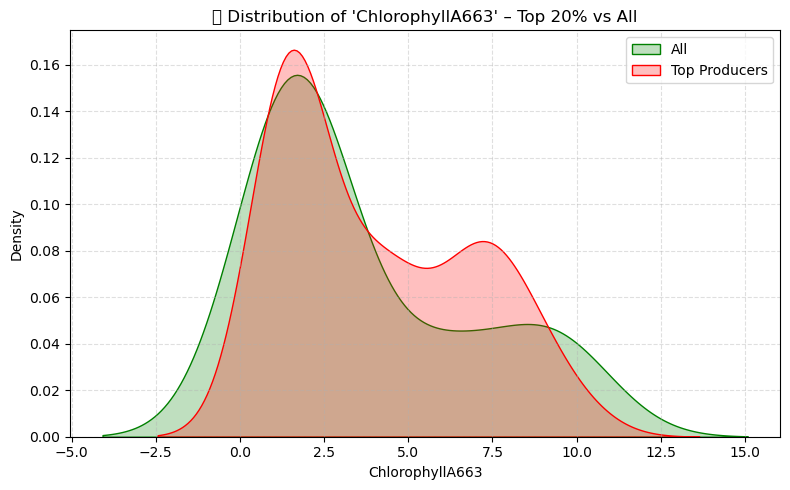

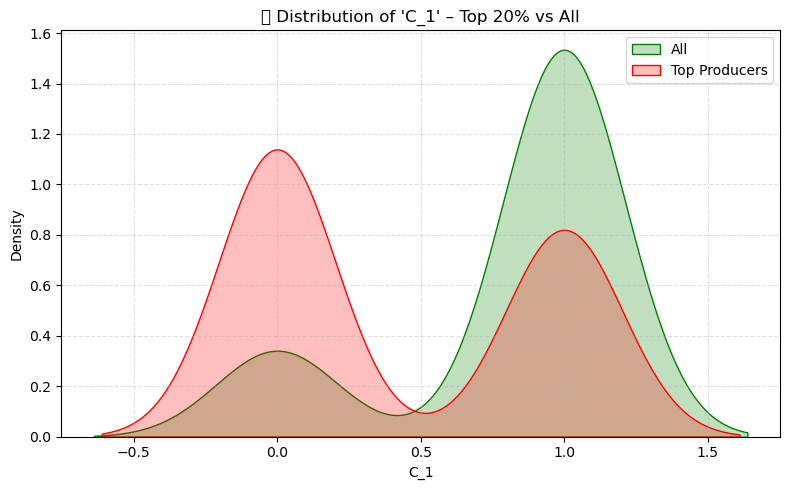

In [ ]:
# Feature Importance: top 5
top_features = shap_values.abs.mean(0).values.argsort()[::-1][:5]
important_feats = X.columns[top_features].tolist()

# Add label for top producers
df_full["Top_Producer"] = df_full["Composite_Yield_Metric"] >= threshold

# Plot each important feature
for feat in important_feats:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df_full, x=feat, hue="Top_Producer", common_norm=False, fill=True, palette=["red", "green"])
    plt.title(f" Distribution of '{feat}' – Top 20% vs All")
    plt.xlabel(feat)
    plt.ylabel("Density")
    plt.legend(labels=["All", "Top Producers"])
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


Extract G, C, S from Parameters

In [111]:
# Decode Parameters into G, C, S
def extract_params(param_str):
    g = param_str.split("G")[1][0]
    s = param_str.split("S")[1][0]
    c = param_str.split("S")[0][-1]
    return int(g), int(s), int(c)

# Apply decoding
df_full[["G", "S", "C"]] = df_full["Parameters"].apply(lambda x: pd.Series(extract_params(x)))


 Count Most Frequent G/S/C Combinations in Top 20%

In [112]:
# Count combos in top producers
combo_counts = df_full[df_full["Top_Producer"]].groupby(["G", "S", "C"]).size().reset_index(name="Top_Producer_Count")

# Add total counts for comparison
total_counts = df_full.groupby(["G", "S", "C"]).size().reset_index(name="Total_Count")

# Merge and calculate frequency
combo_stats = pd.merge(combo_counts, total_counts, on=["G", "S", "C"], how="outer").fillna(0)
combo_stats["Top_Producer_Ratio"] = combo_stats["Top_Producer_Count"] / combo_stats["Total_Count"]

# Sort by highest ratio of top producers
combo_stats = combo_stats.sort_values("Top_Producer_Ratio", ascending=False)

print("🔥 Top G/S/C Combinations Driving High Production:\n")
display(combo_stats.head(10))


🔥 Top G/S/C Combinations Driving High Production:



,G,S,C,Top_Producer_Count,Total_Count,Top_Producer_Ratio
17,4,1,1,3.0,3,1.000000
28,5,3,2,3.0,3,1.000000
6,2,1,1,2.0,3,0.666667
25,5,2,1,2.0,3,0.666667
15,3,3,1,2.0,3,0.666667
0,1,1,1,2.0,3,0.666667
4,1,3,1,2.0,3,0.666667
14,3,2,1,1.0,3,0.333333
16,3,3,2,1.0,3,0.333333
21,4,3,1,1.0,3,0.333333


Optional Heatmap of G vs C (Averaged Over S)

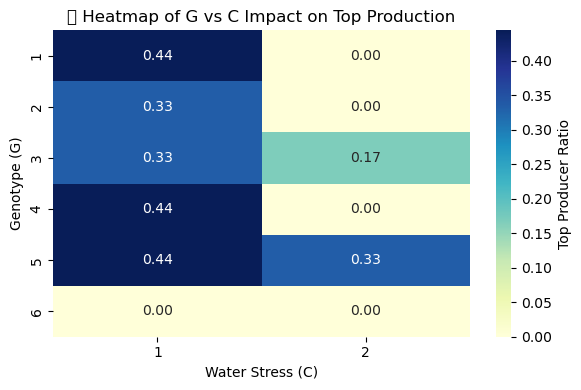

In [113]:
# Heatmap data prep
pivot = combo_stats.pivot_table(values="Top_Producer_Ratio", index="G", columns="C", aggfunc="mean")

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Top Producer Ratio'})
plt.title("🔥 Heatmap of G vs C Impact on Top Production")
plt.xlabel("Water Stress (C)")
plt.ylabel("Genotype (G)")
plt.tight_layout()
plt.show()


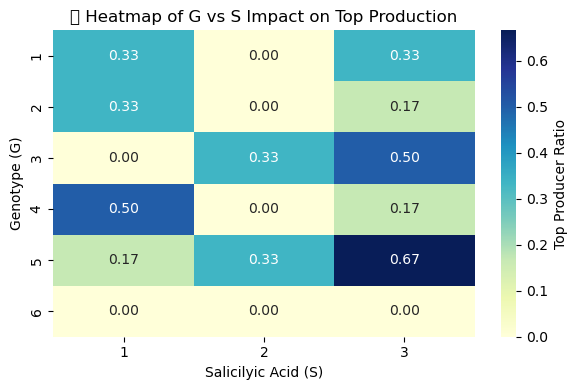

In [114]:
# Heatmap data prep
pivot = combo_stats.pivot_table(values="Top_Producer_Ratio", index="G", columns="S", aggfunc="mean")

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Top Producer Ratio'})
plt.title("🔥 Heatmap of G vs S Impact on Top Production")
plt.xlabel("Salicilyic Acid (S)")
plt.ylabel("Genotype (G)")
plt.tight_layout()
plt.show()

A. Rank Individual Parameters (G, S, C) Based on Composite Productivity
We will train a model to predict whether a sample is in the top 20% producers, using only G, S, C as features. Then we’ll extract feature importances.

1. Prepare Features from G, S, C

In [115]:
# Already decoded G, S, C earlier
X_gsc = df_full[["G", "S", "C"]].astype(int)
y_top = df_full["Top_Producer"].astype(int)  # 1 for top 20%, else 0


2. Train Random Forest Classifier and Get Importance

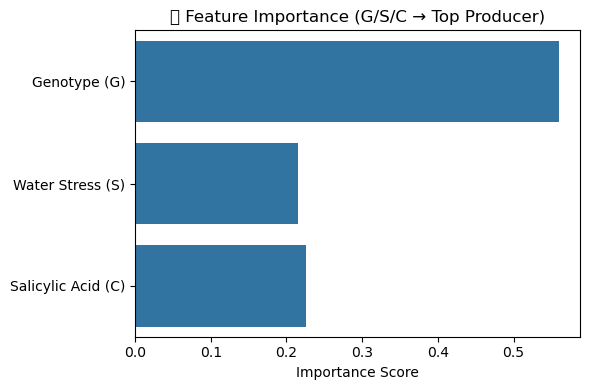

In [116]:
from sklearn.ensemble import RandomForestClassifier

# Train model
rf_gsc = RandomForestClassifier(n_estimators=100, random_state=42)
rf_gsc.fit(X_gsc, y_top)

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x=rf_gsc.feature_importances_, y=["Genotype (G)", "Water Stress (S)", "Salicylic Acid (C)"])
plt.title("🔍 Feature Importance (G/S/C → Top Producer)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


✅ This helps you understand which individual treatment factor matters most in pushing toward higher yield/nutrition.

B. Partial Dependence Plot (PDP) — Visualize Feature Impact
Let’s visualize how each variable (G, S, C) affects the probability of high production.

3. Generate PDP using sklearn

In [117]:
print("Target distribution:")
print(y_top.value_counts())

print("\nFeature types:")
print(X_gsc.dtypes)

print("\nFeature value ranges:")
print(X_gsc.agg(['min', 'max']))

Target distribution:
Top_Producer
0    86
1    22
Name: count, dtype: int64

Feature types:
G    int32
S    int32
C    int32
dtype: object

Feature value ranges:
     G  S  C
min  1  1  1
max  6  3  2


In [118]:
X_gsc
X_gsc["C"][0] = 3
# X_gsc

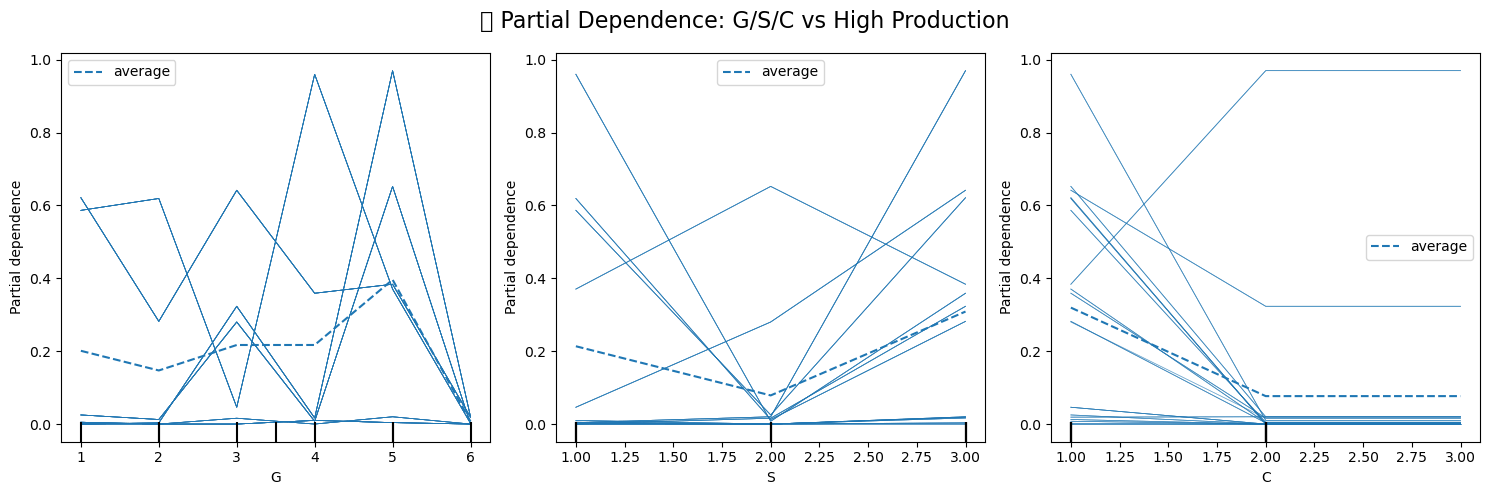

In [119]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

try:
    PartialDependenceDisplay.from_estimator(
        rf_gsc,
        X_gsc,
        features=["G", "S", "C"],  # Use column names instead of indices
        feature_names=["G", "S", "C"],
        target=1,  # Explicitly specify we want PDP for class 1 (top producers)
        ax=ax,
        random_state=42,
        kind="both",
    )
    plt.suptitle("📊 Partial Dependence: G/S/C vs High Production", fontsize=16)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"❌ Error: {str(e)}")

<Figure size 500x400 with 0 Axes>

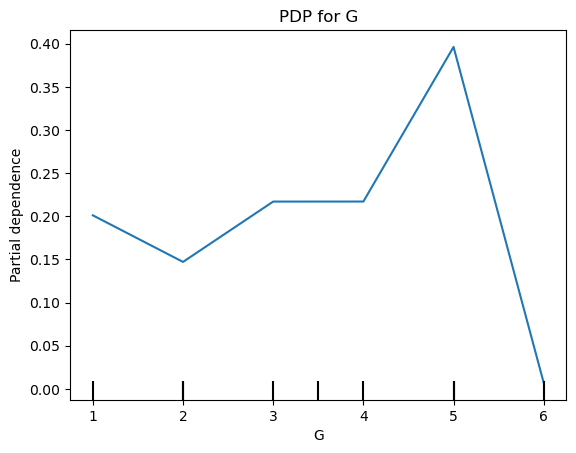

<Figure size 500x400 with 0 Axes>

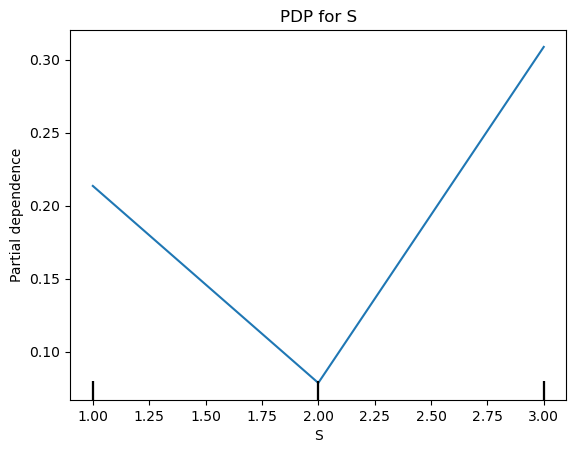

<Figure size 500x400 with 0 Axes>

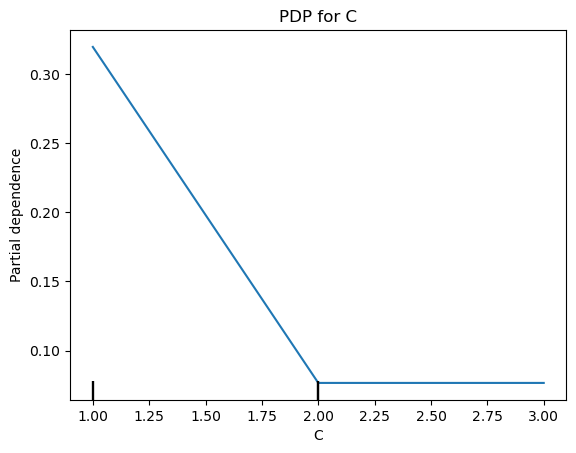

In [120]:
# Plot one feature at a time
for i, feat in enumerate(["G", "S", "C"]):
    plt.figure(figsize=(5, 4))
    PartialDependenceDisplay.from_estimator(
        rf_gsc,
        X_gsc,
        features=[feat],
        target=1
    )
    plt.title(f"PDP for {feat}")
    plt.show()

🌟 Objective
Find the feature ranges or values that result in higher Composite_Yield_Metric (a proxy for good yield + quality).

✅ Phase 1: Train a Regressor
We'll use a regression model to learn the relationship between input features and the target Composite_Yield_Metric.

✔️ Why Regression?
You want to predict a continuous score.

You can later use tools like Partial Dependence Plots (PDP), SHAP, or even Sensitivity Analysis.

✅ Phase 2: Feature Impact Analysis
You suggested a powerful strategy:

“Fix all features, vary one, observe target prediction.”

This is univariate what-if analysis, a simplified but effective optimization heuristic.

1. Preprocessing + Setup

In [121]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Drop unnecessary columns
target_col = "Composite_Yield_Metric"
drop_cols = ["Parameters", "Random ", "Composite_Yield_Metric", "WYUA", "Weight of 300 Seeds (W3S)",
            "Seed Yield per Unit Area (SYUA)", "Protein Percentage (PPE)", "Protein Content (PCO)", "WYUA_scaled", "PPE_scaled", "G", "S", "C", "Top_Producer"]

# Features = all except the calculated columns
X = df_full.drop(columns=drop_cols)
y = df_full[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train a regression model
reg = GradientBoostingRegressor(random_state=42)
reg.fit(X_train, y_train)

# Evaluate
preds = reg.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, preds):.2f}")
print(f"R² Score: {r2_score(y_test, preds):.2f}")

MAE: 11.61
R² Score: -0.06


 2. 🔍 Feature Importance Plot

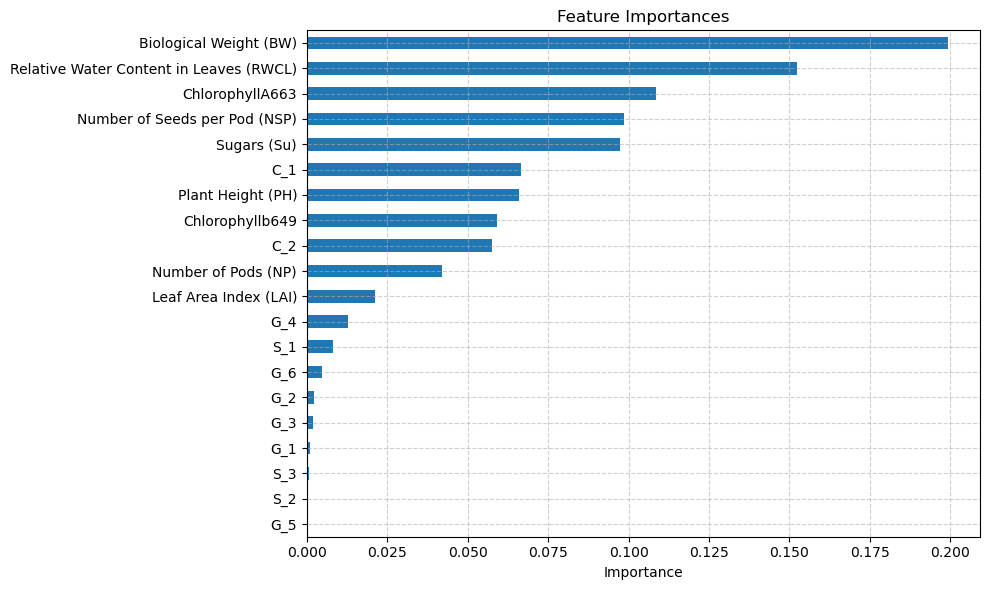

In [122]:
# Feature importances
feat_imp = pd.Series(reg.feature_importances_, index=X.columns)
feat_imp.sort_values(ascending=True).plot(kind="barh", figsize=(10, 6), title="Feature Importances")
plt.xlabel("Importance")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

3. 🎯 One-by-One What-If Optimization (Univariate Range Search)

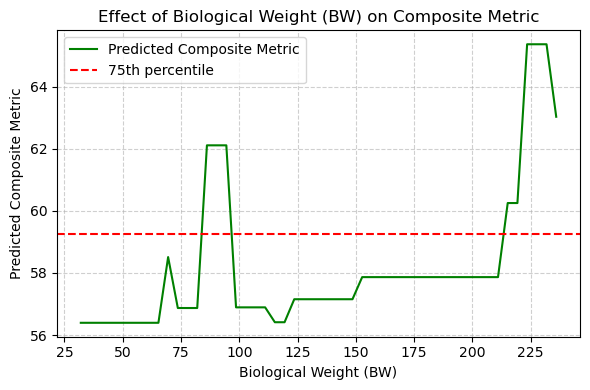

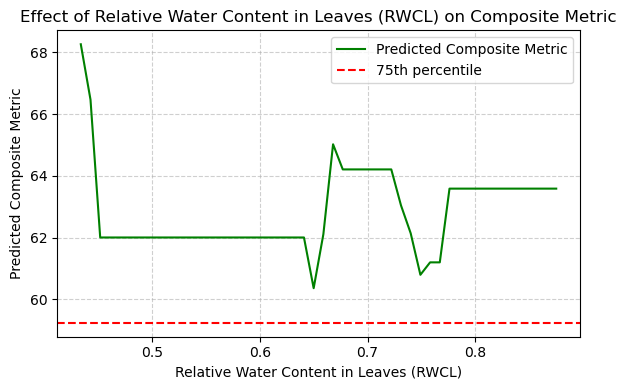

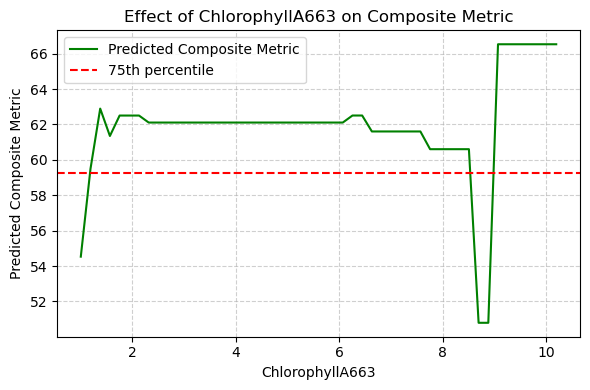

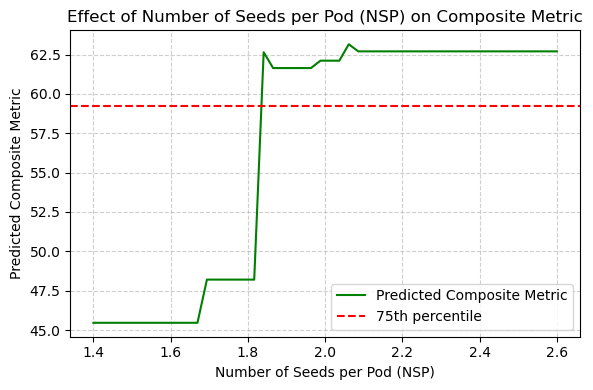

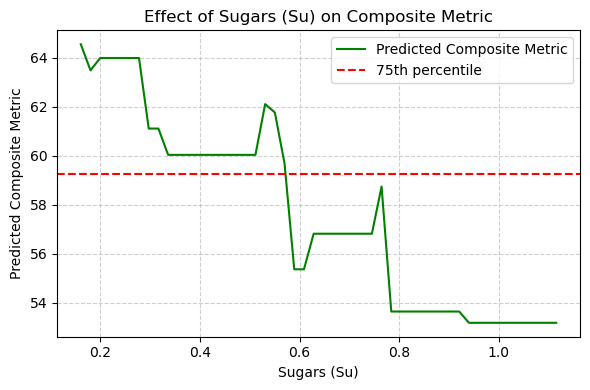

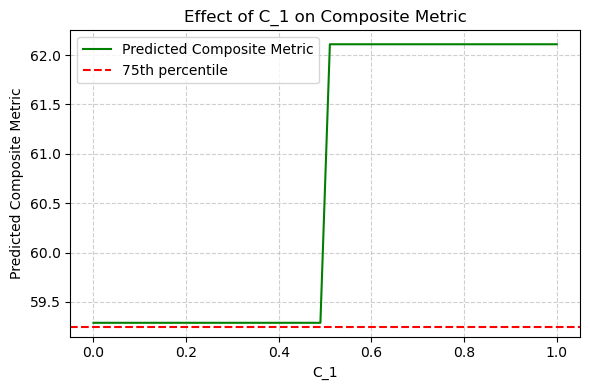

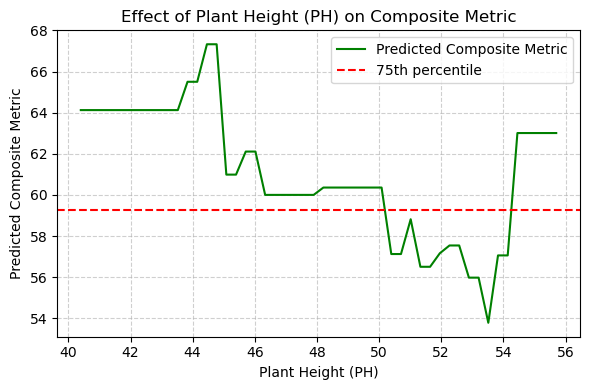

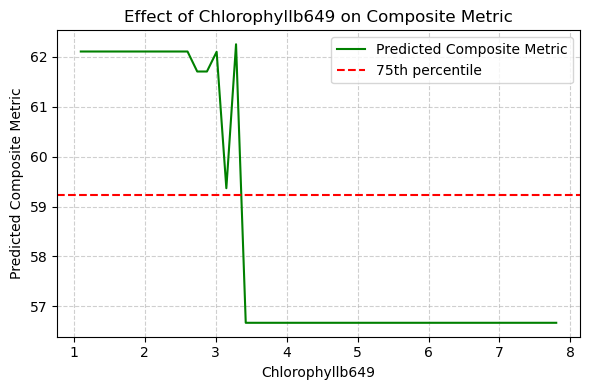

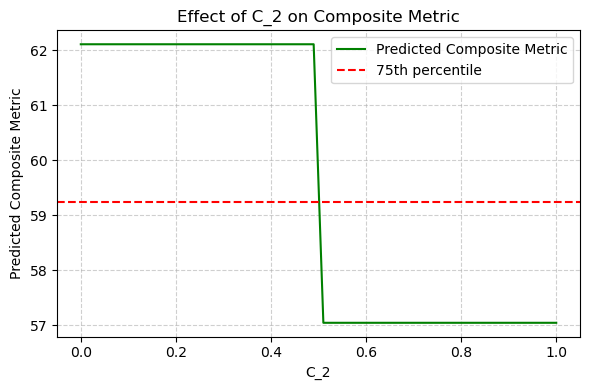

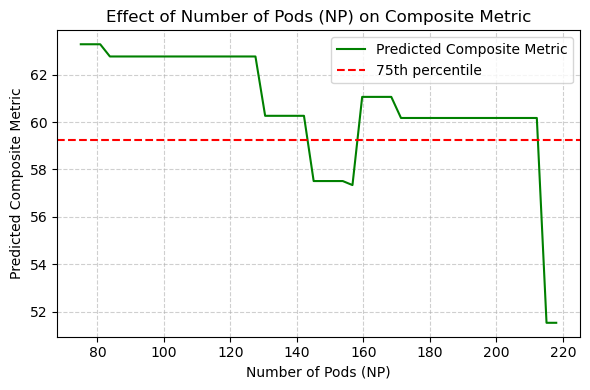

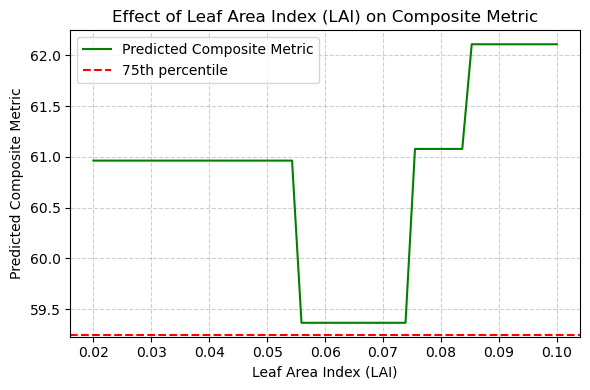

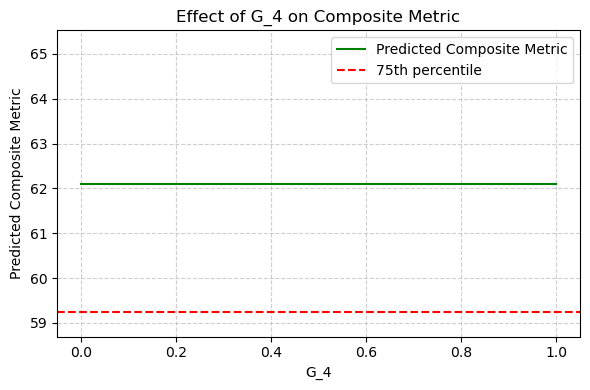

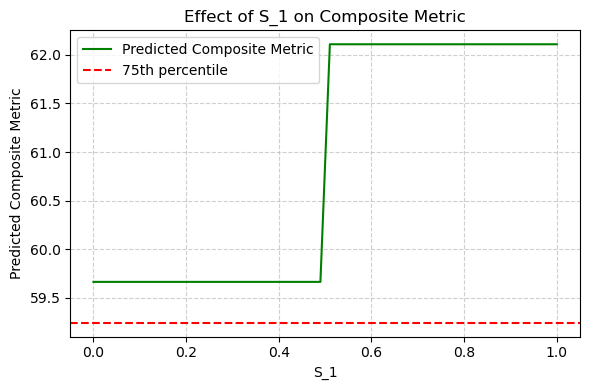

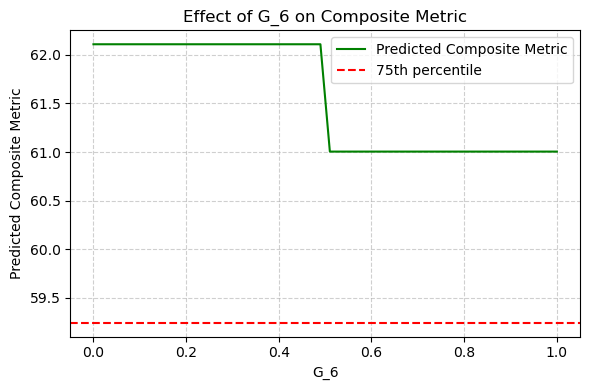

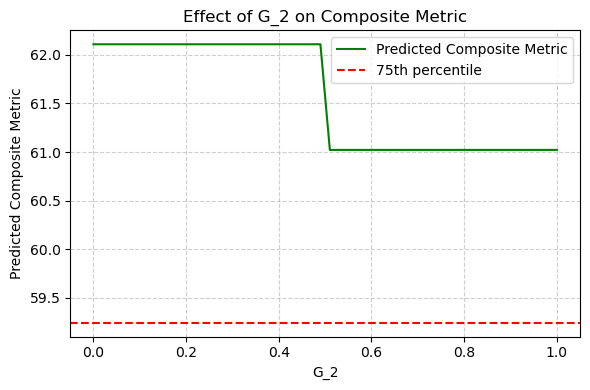

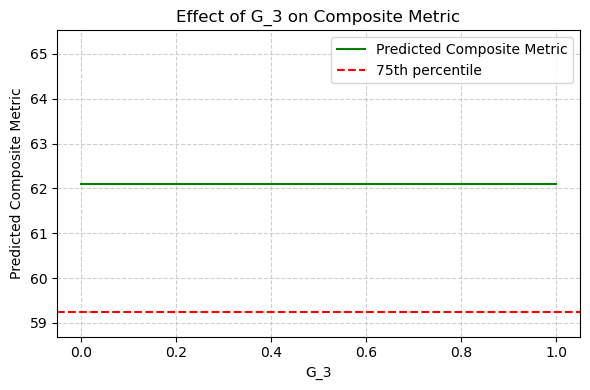

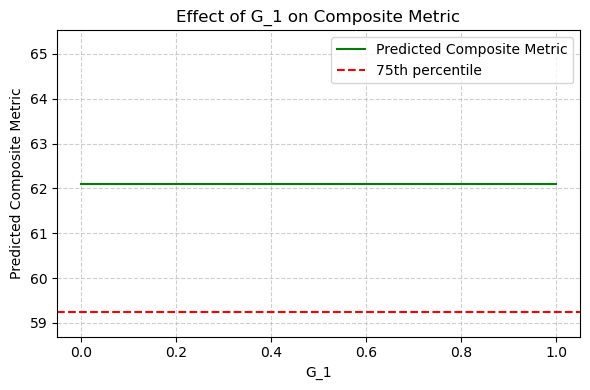

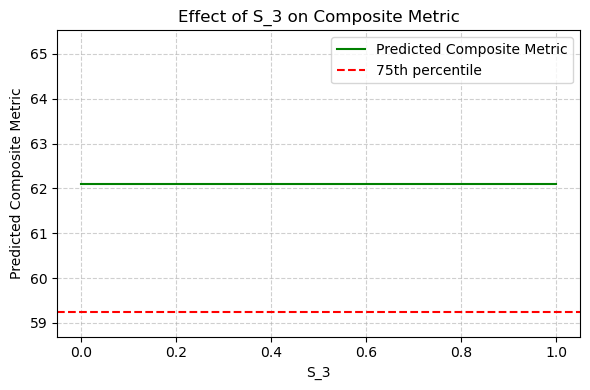

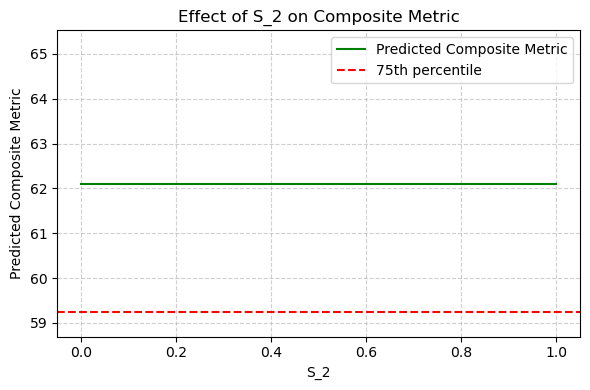

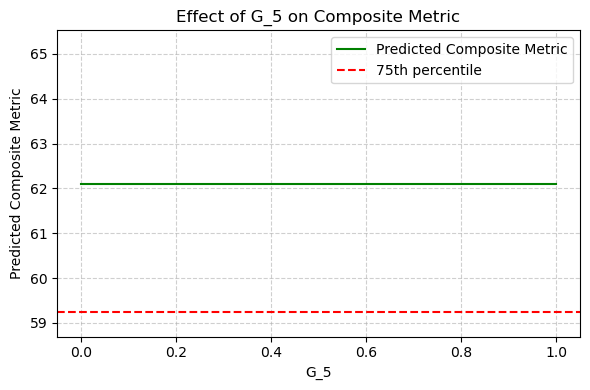

In [123]:
# Function to test one feature at a time
def analyze_feature_effect(feature_name, X_ref, model, steps=50):
    X_temp = X_ref.copy()

    # Get realistic min/max from data
    f_min, f_max = X[feature_name].min(), X[feature_name].max()
    f_values = np.linspace(f_min, f_max, steps)

    preds = []
    for val in f_values:
        X_temp[feature_name] = val
        preds.append(model.predict(X_temp)[0])

    return f_values, preds

# Example: test for multiple features
important_features = feat_imp.sort_values(ascending=False).head(25).index.tolist()
X_baseline = X_train.iloc[[0]].copy()  # use a real row as baseline

for feat in important_features:
    x_vals, y_preds = analyze_feature_effect(feat, X_baseline.copy(), reg)

    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, y_preds, label="Predicted Composite Metric", color="green")
    plt.axhline(y=np.percentile(df_full["Composite_Yield_Metric"], 75), color='r', linestyle='--', label="75th percentile")
    plt.title(f"Effect of {feat} on Composite Metric")
    plt.xlabel(feat)
    plt.ylabel("Predicted Composite Metric")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


4. (Optional) SHAP Analysis for Global + Local Impact

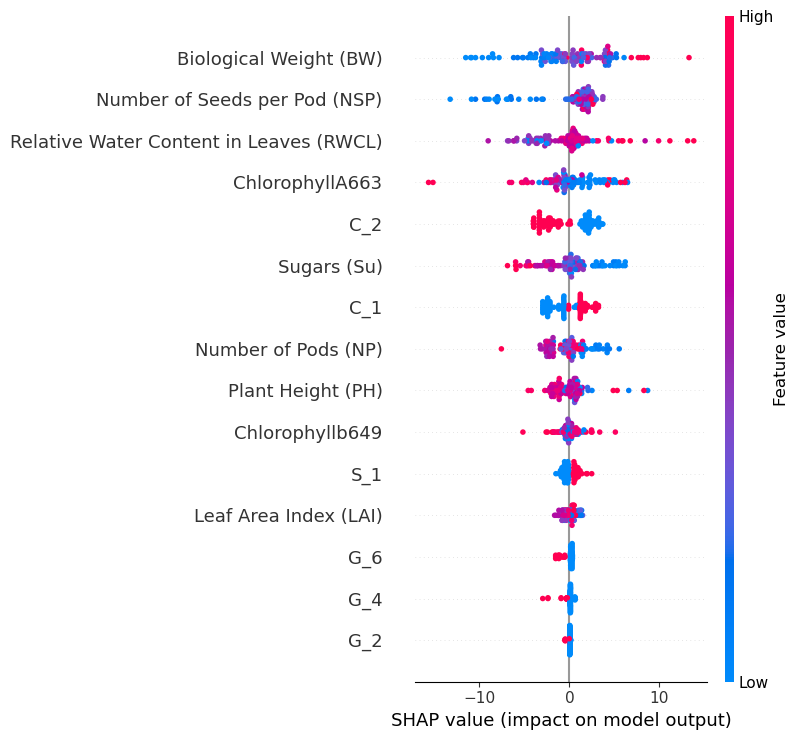

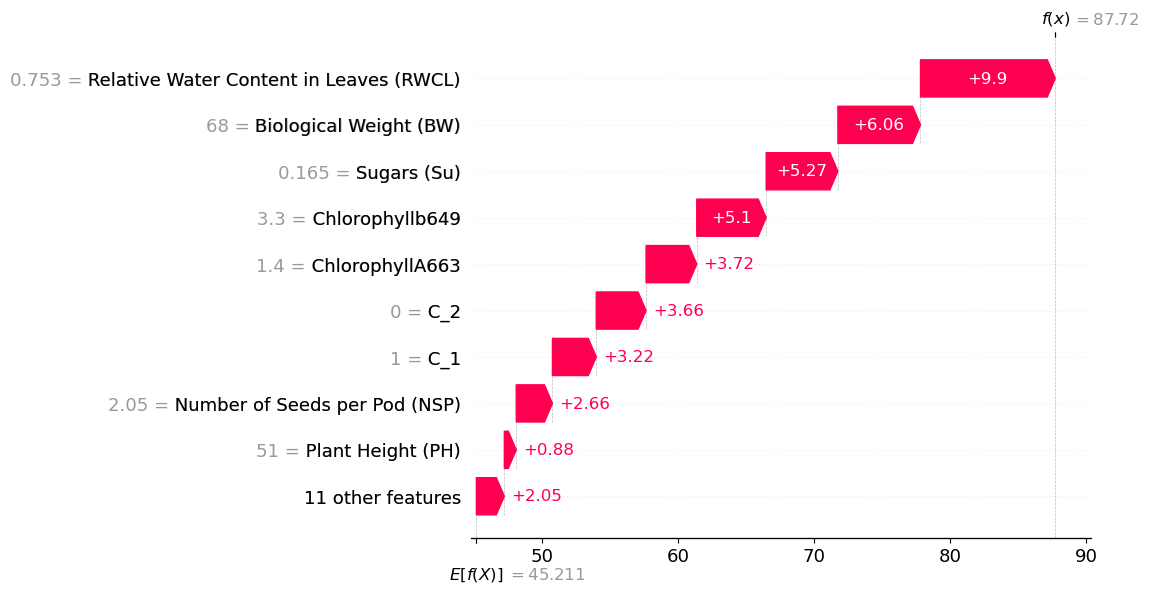

In [124]:
import shap
explainer = shap.Explainer(reg, X)
shap_values = explainer(X)

# Summary plot
shap.summary_plot(shap_values, X, max_display=15)

# Local explanation for a top producer
high_idx = df_full[target_col].idxmax()
shap.plots.waterfall(shap_values[high_idx], max_display=10)


In [125]:
# import joblib

# # Save your trained model (use your best regression model)
# joblib.dump(reg, "regression_model_composite_yield.pkl")

# # Save your MinMaxScaler used for WYUA and PPE
# joblib.dump(scaler, "minmax_scaler_wyua_ppe.pkl")


# For saving models for GUI

In [126]:
# %%
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ---------------------------------------
# 📦 1. Load Data
# ---------------------------------------
df_full = pd.read_csv("3_one_hot_encoded.csv").drop_duplicates()
df_full.replace({True: 1, False: 0}, inplace=True)

# ---------------------------------------
# 🎯 2. Compute Composite Yield Metric
# ---------------------------------------
df_full = df_full.dropna(subset=["Weight of 300 Seeds (W3S)", "Seed Yield per Unit Area (SYUA)", "Protein Percentage (PPE)"])

df_full["WYUA"] = (df_full["Weight of 300 Seeds (W3S)"] / 300) * df_full["Seed Yield per Unit Area (SYUA)"]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_full[["WYUA", "Protein Percentage (PPE)"]])
df_full["WYUA_scaled"] = scaled_features[:, 0]
df_full["PPE_scaled"] = scaled_features[:, 1]
df_full["Composite_Yield_Metric"] = ((df_full["WYUA_scaled"] + df_full["PPE_scaled"]) / 2) * 100

# ---------------------------------------
# 🧹 3. Drop Unwanted Columns
# ---------------------------------------

drop_cols = [
    "Parameters", "Random ", "Composite_Yield_Metric",
    "WYUA", "WYUA_scaled", "PPE_scaled",
    "Seed Yield per Unit Area (SYUA)", "Protein Percentage (PPE)", "Weight of 300 Seeds (W3S)", 
    "Protein Content (PCO)", "Top_Producer"
]

X = df_full.drop(columns=drop_cols, errors='ignore')
y = df_full["Composite_Yield_Metric"]

# ---------------------------------------
# 🔁 4. Train Model
# ---------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
reg = GradientBoostingRegressor(random_state=42)
reg.fit(X_train, y_train)

# Evaluate
preds = reg.predict(X_test)
print(f"✅ MAE: {mean_absolute_error(y_test, preds):.2f}")
print(f"✅ R² Score: {r2_score(y_test, preds):.2f}")

# ---------------------------------------
# 💾 5. Save Model and Scaler for GUI
# ---------------------------------------
joblib.dump(reg, "regression_model_composite_yield.pkl")
joblib.dump(scaler, "minmax_scaler_wyua_ppe.pkl")

print("✅ Model and scaler saved successfully!")


✅ MAE: 11.61
✅ R² Score: -0.06
✅ Model and scaler saved successfully!


In [127]:
# ---------------------------------------
# 💾 5. Save Model, Scaler, and Feature Names
# ---------------------------------------
joblib.dump(reg, "regression_model_composite_yield.pkl")
joblib.dump(scaler, "minmax_scaler_wyua_ppe.pkl")
joblib.dump(X.columns.tolist(), "feature_names_expected.pkl")  # 🔁 NEW

print("✅ Model, scaler, and feature names saved successfully!")


✅ Model, scaler, and feature names saved successfully!


In [128]:
df_full.describe()

,Plant Height (PH),Number of Pods (NP),Biological Weight (BW),Sugars (Su),Relative Water Content in Leaves (RWCL),ChlorophyllA663,Chlorophyllb649,Protein Percentage (PPE),Weight of 300 Seeds (W3S),Leaf Area Index (LAI),...,G_1,G_2,G_3,G_4,G_5,G_6,WYUA,WYUA_scaled,PPE_scaled,Composite_Yield_Metric
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,...,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,49.959259,144.936111,114.527778,0.477546,0.673630,3.937963,2.399074,36.042593,35.349074,0.072130,...,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,526.223232,0.348700,0.561658,45.517889
std,3.066431,20.113791,49.150248,0.237392,0.084902,2.859701,1.192931,2.428499,5.022929,0.022384,...,0.374415,0.374415,0.374415,0.374415,0.374415,0.374415,199.684082,0.209675,0.275966,17.439039
min,40.400000,75.000000,32.000000,0.161000,0.434000,1.000000,1.100000,31.100000,26.400000,0.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,194.139400,0.000000,0.000000,6.454666
25%,49.200000,131.150000,79.750000,0.294750,0.632750,1.475000,1.300000,33.600000,32.200000,0.057500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,394.791000,0.210691,0.284091,34.029898
50%,50.300000,147.000000,101.000000,0.464500,0.677000,2.350000,2.200000,36.600000,34.500000,0.080000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,481.912300,0.302172,0.625000,45.557534
75%,52.000000,158.000000,132.250000,0.612250,0.722250,6.750000,3.100000,38.000000,37.225000,0.090000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,630.786550,0.458495,0.784091,59.242360
max,55.700000,218.000000,236.000000,1.115000,0.875000,10.200000,7.800000,39.900000,53.900000,0.100000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1146.488933,1.000000,1.000000,89.772727


In [133]:
df_full[df_full['Composite_Yield_Metric']>=80]

,Parameters,Random,Plant Height (PH),Number of Pods (NP),Biological Weight (BW),Sugars (Su),Relative Water Content in Leaves (RWCL),ChlorophyllA663,Chlorophyllb649,Protein Percentage (PPE),...,G_1,G_2,G_3,G_4,G_5,G_6,WYUA,WYUA_scaled,PPE_scaled,Composite_Yield_Metric
17,C1S1G1,R2,51.0,142.0,68,0.165,0.753,1.4,3.3,38.1,...,1,0,0,0,0,0,1146.488933,1.000000,0.795455,89.772727
65,C1S3G3,R3,55.2,164.0,233,0.244,0.434,2.3,3.0,38.5,...,0,0,1,0,0,0,1076.859600,0.926887,0.840909,88.389794


In [155]:
# %%
# ---------------------------------------------------
# 🤖 Try Robust Regression: Huber & RANSAC
# ---------------------------------------------------
from sklearn.linear_model import HuberRegressor, RANSACRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Reuse X and y from earlier (composite metric)
print("✅ Shape of training data:", X.shape)

# ------------------ Huber Regressor ------------------
huber = HuberRegressor()
huber.fit(X_train, y_train)
huber_preds = huber.predict(X_test)

print("\n📊 Huber Regressor Results:")
print(f"MAE: {mean_absolute_error(y_test, huber_preds):.2f}")
print(f"R² Score: {r2_score(y_test, huber_preds):.2f}")
print(f"%Accuracy: {100*np.mean(np.isclose(y_test, huber_preds, atol=10)):2.1f}%")

# ------------------ RANSAC Regressor ------------------
ransac = RANSACRegressor(random_state=42)
ransac.fit(X_train, y_train)
ransac_preds = ransac.predict(X_test)

print("\n📊 RANSAC Regressor Results:")
print(f"MAE: {mean_absolute_error(y_test, ransac_preds):.2f}")
print(f"R² Score: {r2_score(y_test, ransac_preds):.2f}")
print(f"%Accuracy: {100*np.mean(np.isclose(y_test, ransac_preds, atol=10)):2.1f}%")

✅ Shape of training data: (108, 18)

📊 Huber Regressor Results:
MAE: 10.09
R² Score: 0.29
%Accuracy: 63.6%

📊 RANSAC Regressor Results:
MAE: 16.69
R² Score: -0.64
%Accuracy: 27.3%


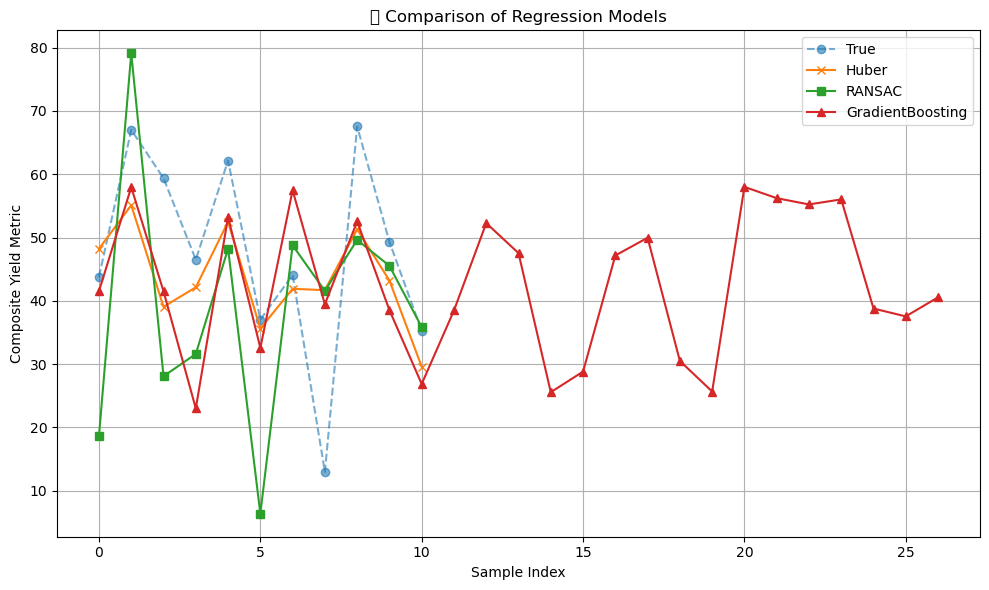

In [156]:
# %%
# Plot predictions vs true values for all models
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="True", linestyle='--', marker='o', alpha=0.6)
plt.plot(huber_preds, label="Huber", marker='x')
plt.plot(ransac_preds, label="RANSAC", marker='s')
plt.plot(preds, label="GradientBoosting", marker='^')
plt.title("🔍 Comparison of Regression Models")
plt.ylabel("Composite Yield Metric")
plt.xlabel("Sample Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [160]:
# Save best model (e.g., HBUBER)
joblib.dump(huber, "regression_model_composite_yield.pkl")
print("✅ Replaced model with HUBER for better robustness.")


✅ Replaced model with HUBER for better robustness.


In [158]:
# %%
# -----------------------------------------------
# 🚀 XGBoost Regressor for Composite Yield Metric
# -----------------------------------------------
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# Reuse X_train, y_train, X_test, y_test from before

xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, xgb_preds)
r2 = r2_score(y_test, xgb_preds)
rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))

print("\n📊 XGBoost Regressor Performance:")
print(f"✅ MAE:  {mae:.2f}")
print(f"✅ R²:   {r2:.3f}")
print(f"✅ RMSE: {rmse:.2f}")
accuracy = np.mean(np.isclose(y_test, xgb_preds, atol=10))
print(f"✅ Accuracy: {100*accuracy:.1f}%")


📊 XGBoost Regressor Performance:
✅ MAE:  12.50
✅ R²:   0.176
✅ RMSE: 14.01
✅ Accuracy: 27.3%


<Figure size 1000x600 with 0 Axes>

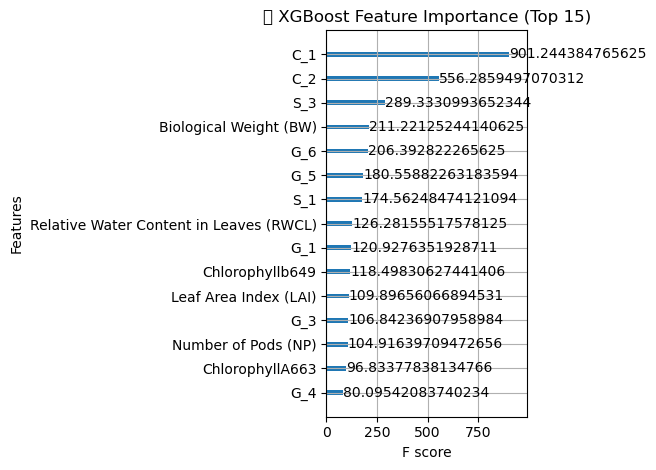

In [159]:
# %%
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=15, importance_type="gain")
plt.title("📌 XGBoost Feature Importance (Top 15)")
plt.tight_layout()
plt.show()
